In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import plotly.graph_objs as go
import skdim


In [2]:
u_lim = 5
a, b, c = 0.05, 0.05, 0.05

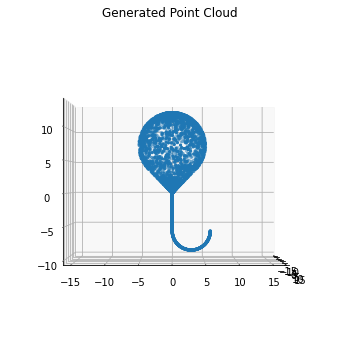

In [6]:
def generate_ballon(a, b, c, u_lim = 5, J_length = 6, J_radius = 3, num_points=5000, shuffle = True):
    num_hyper = int(num_points * 0.4)
    num_sphere = int(num_points * 0.4)
    num_J = int(num_points * 0.2)
    
    #generate hyperboloid upper
    u = np.random.uniform(0, u_lim, num_hyper)
    v = np.random.uniform(0, 2 * np.pi, num_hyper)

    x_h = a*np.cosh(u)*np.cos(v)
    y_h = b*np.cosh(u)*np.sin(v)
    z_h = c*np.sinh(u)

    hyper = np.column_stack((x_h, y_h, z_h))
    
    #generate sphere upper
    theta = np.random.uniform(0, 2 * np.pi, num_sphere)
    phi = np.random.uniform(0, np.pi/2 + np.arctan((b*np.sinh(u_lim))/(c*np.cosh(u_lim))), num_sphere)
    
    radius = np.sqrt(b**2 * np.cosh(u_lim)**2 + (b**4 * np.sinh(u_lim)**2)/c**2)

    x_s = radius * np.sin(phi) * np.cos(theta)
    y_s = radius * np.sin(phi) * np.sin(theta)
    z_s = radius * np.cos(phi) + b**2 * np.sinh(u_lim)/c + c*np.sinh(u_lim)
    
    sphere = np.column_stack((x_s, y_s, z_s))
    
    #generate J shape
    total = J_length + np.pi * J_radius
    ratio_1 = J_length/total
    num_1 = int(num_J * ratio_1)
    t = np.linspace(0, - J_length, num_1)
    x1, y1 = np.zeros(num_1), np.zeros(num_1)
    z1 = t
    X1 = np.zeros((num_1,3))
    X1[:, 0] = x1
    X1[:, 1] = y1
    X1[:, 2] = z1
    
    num_2 = num_J - num_1
    theta = np.linspace(np.pi, 2*np.pi, num_2)
    x2 = np.zeros(num_2)
    y2 = J_radius + J_radius * np.cos(theta)
    z2 = -J_length + J_radius * np.sin(theta)
    X2 = np.zeros((num_2,3))
    X2[:, 0] = x2
    X2[:, 1] = y2
    X2[:, 2] = z2
    
    J = np.concatenate((X1, X2), axis= 0)
    
    Y = np.concatenate((hyper, sphere, J), axis= 0)
    if shuffle:
        np.random.shuffle(Y)

    return Y


np.random.seed(40)
# Generate a sphere point cloud with 1000 points and radius 1
cloud = generate_ballon(a, b, c,u_lim = u_lim, shuffle = False)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

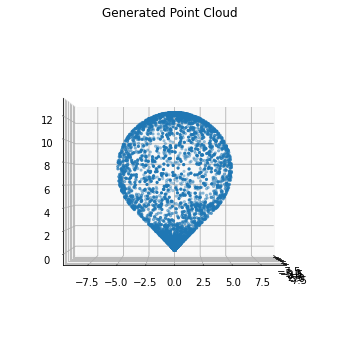

In [9]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:4000, 0], cloud[:4000, 1], cloud[:4000, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

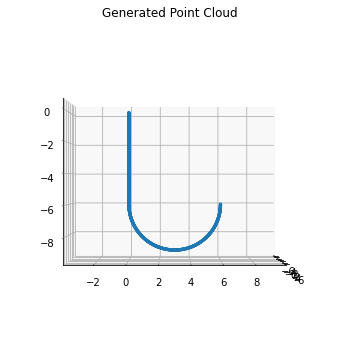

In [11]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[4000:, 0], cloud[4000:, 1], cloud[4000:, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

In [25]:
import skdim
Y1 = cloud[:4000]
Y2 = cloud[4000:]
#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(Y1)
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(Y1,
                              n_neighbors = 10,
                              n_jobs = 1)

#get estimated intrinsic dimension
print(danco.dimension_, np.mean(lpca.dimension_pw_))

2.2272727893458097 2.0


In [26]:
lpca.dimension_pw_

array([2, 2, 2, ..., 2, 2, 2])

In [22]:
#danco = skdim.id.DANCo().fit(Y2)
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(Y2, n_neighbors = 10, n_jobs = 1)

#get estimated intrinsic dimension
print(np.mean(lpca.dimension_pw_))

1.0


In [24]:
lpca.dimension_pw_[1]

1

In [14]:

# Generate data
data1, clusters = skdim.datasets.lineDiskBall(n=2000, random_state=0)

# Plot only the first dataset (data1)
trace1 = go.Scatter3d(dict(zip(['x', 'y', 'z'], cloud.T[:3])),
                     mode='markers', marker=dict(size=1.5, colorbar=dict()))

layout = go.Layout(scene=dict(aspectmode="cube"))

fig = go.Figure(data=[trace1], layout=layout)
fig.update_layout(scene=dict(aspectmode="cube"))

# Save the figure as an HTML file
fig.write_html("my_3d_plot.html")


In [15]:

# Plot only the first dataset (data1)
trace1 = go.Scatter3d(dict(zip(['x', 'y', 'z'], cloud.T[:3])),
                     mode='markers', marker=dict(size=1.5, colorbar=dict()))

layout = go.Layout(scene=dict(aspectmode="cube"))

fig = go.Figure(data=[trace1], layout=layout)

# Compute local intrinsic dimensions using lPCA
pca = skdim.id.lPCA()
lid1 = pca.fit_pw(cloud, n_neighbors=50).dimension_pw_

# Update the trace properties
fig.update_traces({'text': lid1, 'marker.color': lid1, 'marker.colorbar': dict(thickness=5, x=.80)}, selector=dict(type='scatter3d'))

# Save the figure as an HTML file
fig.write_html("dim_plot.html")


In [150]:
trace1

Scatter3d({
    'marker': {'size': 1.5},
    'mode': 'markers',
    'x': array([-0.14894923, -0.12619483,  0.18870879]),
    'y': array([-0.03204469,  0.04086159,  0.01401898]),
    'z': array([-0.86325033,  0.95777427,  1.28842256])
})

In [145]:
lid1.shape

(2000,)